In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [16]:
def omega2w(omega, p, t):
    ''' converts vertical velocity from pressure coords
        to m/s.
        
        input:
         - omega : array in units of Pa/s
         - p     : pressure array in Pa
         - t     : temperature array in K
        output:
         - w     : vertical velocity array in units of m/s
    '''
    R    = 287.058
    G    = 9.80665
    rho = p / (R*t)
    w = -omega/(rho*G)
    return w

def calc_rhice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] +
                  3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

In [2]:
iop_dir = "/glade/work/sturbeville/E3SM/inputdata/atm/cam/scam/iop/"
# iop_file = "RCE_iopfile_4scam_no-mean-ascent.nc"
# iop_file = "RCE_iopfile_4scam_smooth_w_profile.nc"
# iop_file = "RCE_iopfile_4scam_smooth-mean-ascent.nc"
iop_file = "RCE_iopfile_4scam_no-mean-ascent_304K.nc"
iop_file_304k = "RCE_iopfile_4scam_smooth_w_profile_304K.nc"
new_iop_file = "RCE_iopfile_4scam_smooth_w_profile_304K_new.nc"

In [13]:
iop_ds = xr.open_dataset(iop_dir+iop_file)
iop = iop_ds.isel(lat=0).isel(time=0).isel(lon=0)

iop304_ds = xr.open_dataset(iop_dir+iop_file_304k)
iop304 = iop304_ds.isel(lat=0).isel(time=0).isel(lon=0)

iop_tosave_ds = iop_ds
iop_tosave_ds

<xarray.Dataset> Size: 5kB
Dimensions:  (lon: 1, lat: 1, lev: 72, time: 2)
Coordinates:
  * lon      (lon) float32 4B 0.0
  * lat      (lat) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables: (12/13)
    tsec     (time) int32 8B ...
    bdate    int32 4B ...
    Ps       (time, lat, lon) float32 8B ...
    Tg       (time, lat, lon) float32 8B ...
    Ptend    (time, lat, lon) float32 8B ...
    phis     (time, lat, lon) float32 8B ...
    ...       ...
    q        (time, lev, lat, lon) float32 576B ...
    u        (time, lev, lat, lon) float32 576B ...
    v        (time, lev, lat, lon) float32 576B ...
    omega    (time, lev, lat, lon) float64 1kB ...
    divT     (time, lev, lat, lon) float32 576B ...
    divq     (time, lev, lat, lon) float32 576B ...
Attributes:
    description:  Forcing for GABLS

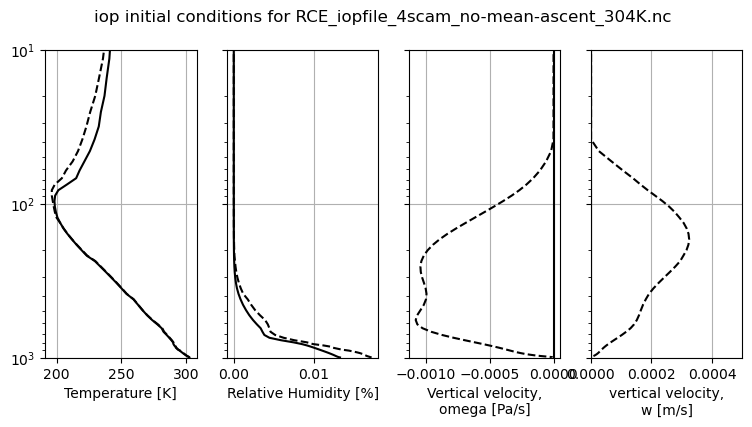

In [20]:
# plot vertical profiles of each initial condition in iop file side-by-side
fig, ax = plt.subplots(1,4, figsize=(9,4), sharey=True)
ax[0].plot(iop["T"], iop.lev/100, 'k')
ax[0].plot(iop304["T"], iop304.lev/100, 'k--')
ax[0].set(xlabel="Temperature [K]")
rhice300 = calc_rhice(iop, varQ="q", z_units="Pa")
rhice304 = calc_rhice(iop304, varQ="q", z_units="Pa")
# ax[1].plot(rhice300, iop.lev/100, 'k')
# ax[1].plot(rhice304, iop.lev/100, 'k--')
ax[1].plot(iop.q, iop.lev/100, 'k')
ax[1].plot(iop304.q, iop.lev/100, 'k--')
ax[1].set(xlabel="Relative Humidity [%]")
ax[2].plot(iop.omega, iop.lev/100, 'k')
ax[2].plot(iop304.omega, iop304.lev/100, 'k--')
ax[2].set(xlabel="Vertical velocity,\nomega [Pa/s]")
w = omega2w(iop.omega, iop.lev, iop["T"])
w304 = omega2w(iop304.omega, iop304.lev, iop304["T"])
ax[3].plot(w, iop.lev/100, 'k')
ax[3].plot(w304, iop304.lev/100, 'k--')
ax[3].set(xlabel="vertical velocity,\nw [m/s]", xlim=[0,0.0005])

for i in range(4):
    ax[i].grid(True)
    if i>0:
        ax[i].set(ylabel="")

ax[0].invert_yaxis()
ax[0].set_yscale("log")
ax[0].set(ylim=[1000,10])
fig.suptitle("iop initial conditions for "+iop_file)
plt.savefig("../plots/iop_ic_{}.png".format(iop_file.split(".")[0]))
plt.show()

# save new iop file

Change something about the iop file from a different file, then save it as a new file

In [13]:
iop_ds.bdate

<xarray.DataArray 'bdate' ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    units:      yyyymmdd
    long_name:  base date

In [21]:
# iop['T'] = iop304['T']
# iop['T']
iop_tosave_ds['lat'].attrs = iop_ds['lat'].attrs
iop_tosave_ds['lon'].attrs = iop_ds['lon'].attrs
iop_tosave_ds['bdate'] = iop_ds['bdate']
iop_tosave_ds

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 1, lon: 1, lev: 72, time: 2)
Coordinates:
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables: (12/13)
    tsec     (time, lat, lon) int32 8B ...
    Ps       (time, lat, lon) float32 8B ...
    Tg       (time, lat, lon) float32 8B ...
    Ptend    (time, lat, lon) float32 8B ...
    phis     (time, lat, lon) float32 8B ...
    T        (time, lev, lat, lon) float32 576B ...
    ...       ...
    u        (time, lev, lat, lon) float32 576B ...
    v        (time, lev, lat, lon) float32 576B ...
    omega    (time, lev, lat, lon) float32 576B ...
    divT     (time, lev, lat, lon) float32 576B ...
    divq     (time, lev, lat, lon) float32 576B ...
    bdate    int32 4B ...
Attributes:
    description:  Forcing for GABLS

In [22]:
iop_tosave_ds.lat


<xarray.DataArray 'lat' (lat: 1)> Size: 4B
array([0.], dtype=float32)
Coordinates:
  * lat      (lat) float32 4B 0.0
Attributes:
    units:      degrees_north
    long_name:  latitude

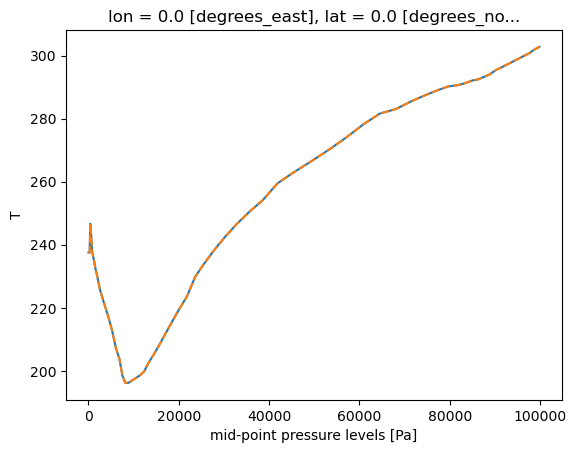

In [12]:
# iop['T'].plot()
# iop304['T'].plot(linestyle="dashed")
# plt.show()

In [15]:
print(iop['T'][0].values, iop['T'][-1].values)

237.54498 302.80533


In [16]:
iop.lev[-1].values

array(99849.64, dtype=float32)

In [17]:
# iop.to_netcdf(iop_dir+"RCE_iopfile_4scam_smooth_w_profile_304k.nc")

In [23]:
# iop304_expand = iop304.expand_dims(dim={'time':iop.time, 'lat':iop.lat, 'lon':iop.lon}, axis=[0,-2,-1])
# iop304_expand

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 2, lat: 1, lon: 1, lev: 72)
Coordinates:
  * time     (time) int64 16B 0 1
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Data variables: (12/13)
    tsec     (time, lat, lon) int32 8B 0 0
    bdate    (time, lat, lon) int32 8B 20000101 20000101
    Ps       (time, lat, lon) float32 8B 1.015e+05 1.015e+05
    Tg       (time, lat, lon) float32 8B 306.0 306.0
    Ptend    (time, lat, lon) float32 8B 0.0 0.0
    phis     (time, lat, lon) float32 8B 0.0 0.0
    ...       ...
    q        (time, lev, lat, lon) float32 576B 1e-12 1e-12 ... 0.01311 0.01329
    u        (time, lev, lat, lon) float32 576B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v        (time, lev, lat, lon) float32 576B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega    (time, lev, lat, lon) float32 576B -2.484e-09 ... -1.133e-05
    divT     (time, lev, lat, lon) float32 576B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    divq     (time, lev, lat, lon) float32 576B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  Forcing for GABLS

In [23]:
iop_tosave_ds.to_netcdf(iop_dir+new_iop_file)

## save q from 304 run to iop file

In [8]:
run_dir = "/glade/work/sturbeville/DPSCREAM_simulations/all_run_files/"
run_file = "scream_dp_RCE_SMALL_3km_j_304K.eam.h0.2000-01-01-00000.nc"

In [9]:
ds = xr.open_dataset(run_dir + run_file)[['T','Q']]


In [10]:
iop304.q.shape, ds.Q.shape

((72,), (362, 128, 1296))

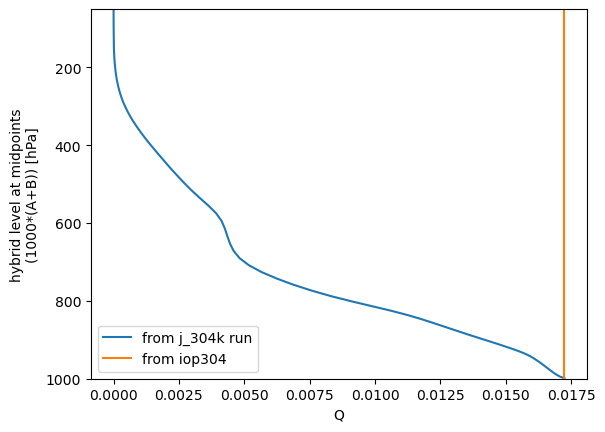

In [11]:
ds.Q.mean(dim=['time','ncol']).plot(y='lev', label="from j_304k run")
plt.plot(iop304.q, iop304.lev/100, label="from iop304")
plt.ylim([1000,50])
plt.legend()
plt.show()

Manipulate the array to save it

In [13]:
ds.Q.lev[-1].values, iop304_tosave.lev[-1].values

(array(998.49642944), array(99849.64, dtype=float32))

In [14]:
new_q = ds.Q.mean(dim=['time','ncol']).sel(lev=iop304_tosave.lev/100,method='nearest')
new_q = new_q.expand_dims({'time':2,'lat':1,'lon':1}, axis=(0,-2,-1))
new_q = xr.DataArray(new_q.values, dims=iop304_tosave.q.dims, coords=iop304_tosave.q.coords,
                    attrs=iop304.q.attrs)
new_q

<xarray.DataArray (time: 2, lev: 72, lat: 1, lon: 1)> Size: 576B
array([[[[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[8.92496320e-12]],

        [[1.24745847e-11]],

...

        [[1.49312457e-02]],

        [[1.54144289e-02]],

        [[1.58040300e-02]],

        [[1.60815343e-02]],

        [[1.62938405e-02]],

        [[1.64780468e-02]],

        [[1.66418813e-02]],

        [[1.68832634e-02]],

        [[1.70824397e-02]],

        [[1.72414426e-02]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Attributes:
    units:      kg
    long_name:  w.v. mixing ratio

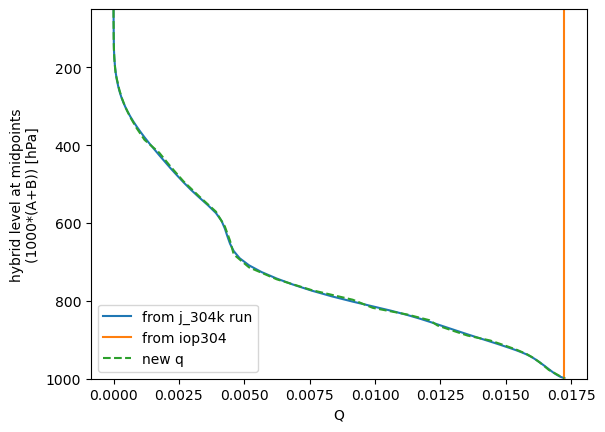

In [15]:
ds.Q.mean(dim=['time','ncol']).plot(y='lev', label="from j_304k run")
plt.plot(iop304.q, iop304.lev/100, label="from iop304")
plt.plot(new_q[0,:,0,0], new_q.lev/100, label="new q", linestyle='dashed')
plt.ylim([1000,50])
plt.legend()
plt.show()

In [16]:
iop304_tosave['q'] = new_q

In [17]:
iop304_tosave

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 1, lon: 1, lev: 72, time: 2)
Coordinates:
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables: (12/13)
    tsec     (time, lat, lon) int32 8B ...
    bdate    (time, lat, lon) int32 8B ...
    Ps       (time, lat, lon) float32 8B ...
    Tg       (time, lat, lon) float32 8B ...
    Ptend    (time, lat, lon) float32 8B ...
    phis     (time, lat, lon) float32 8B ...
    ...       ...
    q        (time, lev, lat, lon) float32 576B 8.925e-12 8.925e-12 ... 0.01724
    u        (time, lev, lat, lon) float32 576B ...
    v        (time, lev, lat, lon) float32 576B ...
    omega    (time, lev, lat, lon) float32 576B ...
    divT     (time, lev, lat, lon) float32 576B ...
    divq     (time, lev, lat, lon) float32 576B ...
Attributes:
    description:  Forcing for GABLS

In [45]:
iop304_tosave = iop304_tosave.drop_vars('time')

In [18]:
iop304_tosave

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 1, lon: 1, lev: 72, time: 2)
Coordinates:
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables: (12/13)
    tsec     (time, lat, lon) int32 8B ...
    bdate    (time, lat, lon) int32 8B ...
    Ps       (time, lat, lon) float32 8B ...
    Tg       (time, lat, lon) float32 8B ...
    Ptend    (time, lat, lon) float32 8B ...
    phis     (time, lat, lon) float32 8B ...
    ...       ...
    q        (time, lev, lat, lon) float32 576B 8.925e-12 8.925e-12 ... 0.01724
    u        (time, lev, lat, lon) float32 576B ...
    v        (time, lev, lat, lon) float32 576B ...
    omega    (time, lev, lat, lon) float32 576B ...
    divT     (time, lev, lat, lon) float32 576B ...
    divq     (time, lev, lat, lon) float32 576B ...
Attributes:
    description:  Forcing for GABLS

In [22]:
iop304_tosave.to_netcdf(iop_dir + "RCE_iopfile_4scam_smooth_w_profile_304ksst_new.nc")

In [21]:
iop304_tosave = iop304_tosave.drop_vars('bdate')
iop304_tosave

/glade/derecho/scratch/sturbeville/tmp/ipykernel_4372/2687684631.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  iop304_tosave = iop304_tosave.drop('bdate')


<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 1, lon: 1, lev: 72, time: 2)
Coordinates:
  * lat      (lat) float32 4B 0.0
  * lon      (lon) float32 4B 0.0
  * lev      (lev) float32 288B 12.38 18.28 26.99 ... 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables:
    tsec     (time, lat, lon) int32 8B ...
    Ps       (time, lat, lon) float32 8B ...
    Tg       (time, lat, lon) float32 8B ...
    Ptend    (time, lat, lon) float32 8B ...
    phis     (time, lat, lon) float32 8B ...
    T        (time, lev, lat, lon) float32 576B ...
    q        (time, lev, lat, lon) float32 576B 8.925e-12 8.925e-12 ... 0.01724
    u        (time, lev, lat, lon) float32 576B ...
    v        (time, lev, lat, lon) float32 576B ...
    omega    (time, lev, lat, lon) float32 576B ...
    divT     (time, lev, lat, lon) float32 576B ...
    divq     (time, lev, lat, lon) float32 576B ...
Attributes:
    description:  Forcing for GABLS